# Lecture 6, Heat transports

> Two-dimensional advection-diffusion of heat


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import HTML
from IPython.display import display

# 1) Background: two-dimensional advection-diffusion

## 1.1) The two-dimensional advection-diffusion equation
Recall from **Lecture 5** that the one-dimensional advection-diffusion equation is written as

$$\frac{\partial T(x,t)}{\partial t} = -U \frac{\partial T}{\partial x} + \kappa \frac{\partial^{2} T}{\partial x^{2}},$$

where $T(x, t)$ is the temperature, $U$ is a constant advective velocity and $\kappa$ is the diffusivity.

The two-dimensional advection diffusion equation simply adds advection and diffusion operators acting in a second dimensions $y$ (orthogonal to $x$). 

$$\frac{\partial T(x,y,t)}{\partial t} = u(x,y) \frac{\partial T}{\partial x} + v(x,y) \frac{\partial T}{\partial y} + \kappa \left( \frac{\partial^{2} T}{\partial x^{2}} + \frac{\partial^{2} T}{\partial y^{2}} \right),$$

where $\vec{u}(x,y) = (u, v) = u\,\mathbf{\hat{x}} + v\,\mathbf{\hat{y}}$ is a velocity vector field.

Throughout the rest of the Climate Modelling module, we will consider $x$ to be the *longitundinal* direction (positive from west to east) and $y$ to the be the *latitudinal* direction (positive from south to north).

## 1.2) Multivariable shorthand notation

Conventionally, the two-dimensional advection-diffusion equation is written more succintly as

$$\frac{\partial T(x,y,t)}{\partial t} = - \vec{u} \cdot \nabla T + \kappa \nabla^{2} T,$$

using the following shorthand notation.

The **gradient** operator is defined as 

$\nabla \equiv (\frac{\partial}{\partial x}, \frac{\partial }{\partial y})$

such that

$\nabla T = (\frac{\partial T}{\partial x}, \frac{\partial T}{\partial y})$ and 

$\vec{u} \cdot \nabla T = (u, v) \cdot (\frac{\partial T}{\partial x}, \frac{\partial T}{\partial y}) = u \frac{\partial T}{\partial x} + v\frac{\partial T}{\partial y}.$

The **Laplacian** operator $\nabla^{2}$ (sometimes denoted $\Delta$) is defined as 

$\nabla^{2} = \frac{\partial^{2}}{\partial x^{2}} + \frac{\partial^{2}}{\partial y^{2}}$

such that

$\nabla^{2} T = \frac{\partial^{2} T}{\partial x^{2}} + \frac{\partial^{2} T}{\partial y^{2}}.$

The **divergence** operator is defined as $\nabla \cdot [\quad]$, such that

$\nabla \cdot \vec{u} = \left(\frac{\partial}{\partial x}, \frac{\partial}{\partial x} \right) \cdot (u,v) = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}.$

**Note:** Since seawater is largely incompressible, we can approximate ocean currents as a *non-divergent flow*, with $\nabla \cdot \vec{u} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$. Among other implications, this allows us to write:

\begin{align}
\vec{u} \cdot \nabla T&=
u\frac{\partial T(x,y,t)}{\partial x} + v\frac{\partial T(x,y,t)}{\partial y}\newline &=
u\frac{\partial T}{\partial x} + v\frac{\partial T}{\partial y} + T\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}\right)\newline &=
\left( u\frac{\partial T}{\partial x} + T\frac{\partial u}{\partial x} \right) +
\left( v\frac{\partial T}{\partial y} + \frac{\partial v}{\partial y} \right)
\newline &=
\frac{\partial (uT)}{\partial x} + \frac{\partial (vT)}{\partial x}\newline &=
\nabla \cdot (\vec{u}T)
\end{align}

using the product rule (separately in both $x$ and $y$).


##### 1.3) The flux-form two-dimensional advection-diffusion equation

This lets us finally re-write the two-dimensional advection-diffusion equation as:

$\frac{\partial T}{\partial t} = - \nabla \cdot (\vec{u}T) + \kappa \nabla^{2} T$

which is the form we will use in our numerical algorithm below.

# 2) Numerical implementation

# 2.1) Discretizing advection in two dimensions

In Lecture XX we saw that in one dimension we can discretize a first-partial derivative in space using the *centered finite difference*

$$\frac{\partial T(x_{i}, t_{n})}{\partial x} \approx \frac{T_{i+1}^{n} - T_{i-1}^{n}}{2 \Delta x}.$$

In two dimensions, we discretize the partial derivative the exact same way, except that we also need to keep track of the cell index $j$ in the $y$ dimension:

$$\frac{\partial T(x_{i}, y_{j}, t_{n})}{\partial x} \approx \frac{T_{i+1,\, j}^{n} - T_{i-1,\,j}^{n}}{2 \Delta x}.$$

The *x-gradient kernel* below, is shown below, and is reminiscent of the *edge-detection* or *sharpening* kernels used in image processing and machine learning:

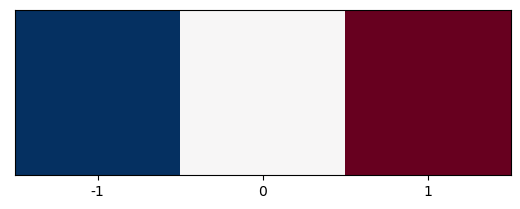

In [2]:
plt.imshow([[-1,0,1]], cmap=plt.cm.RdBu_r)
plt.xticks([0,1,2], labels=[-1,0,1]);
plt.yticks([]);

The first-order partial derivative in $y$ is similarly discretized as:

$$\frac{\partial T(x_{i}, y_{j}, t_{n})}{\partial y} \approx \frac{T_{i,\, j+1}^{n} - T_{i,\,j-1}^{n}}{2 \Delta y}.$$

Its kernel is shown below.

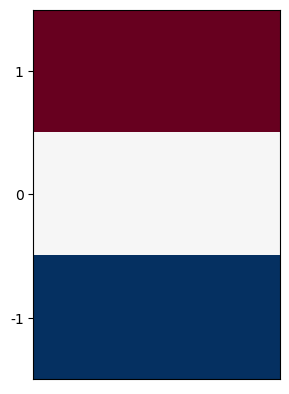

In [3]:
plt.imshow([[-1,-1],[0,0],[1,1]], cmap=plt.cm.RdBu);
plt.xticks([]);
plt.yticks([0,1,2], labels=[1,0,-1]);

Now that we have discretized the two derivate terms, we can write out the *advective tendency* for computing $T_{i, j, n+1}$ as

$$u\frac{\partial T}{\partial x} + v\frac{\partial T}{\partial y} \approx u_{i,\, j}^{n} \frac{T_{i,\, j+1}^{n} - T_{i,\,j-1}^{n}}{2 \Delta y} + v_{i,\, j}^{n} \frac{T_{i,\, j+1}^{n} - T_{i,\,j-1}^{n}}{2 \Delta y}.$$

We implement this as a the `advect` function. This computes the advective tendency for the $(i,j)$ grid cell.

In [4]:
xkernel = np.zeros((1,3))
xkernel[0, :] = np.array([-1,0,1])

In [5]:
ykernel = np.zeros((3,1))
ykernel[:, 0] = np.array([-1,0,1])

In [6]:
class OceanModel:
    
    def __init_(self,T, u, v, deltax, deltay):
        self.T = [T] 
        self.u = u
        self.v = v
        self.deltax = deltax
        self.deltay = deltay
        self.j = np.arange(0, self.T[0].shape[0])
        self.i = np.arange(0, self.T[0].shape[1])
        
    def advect(self, T):
        T_advect = np.zeros((self.j.size, self.i.size))
        
        for j in range(1, T_advect.shape[0] - 1):
            for i in range(1, T_advect.shape[1] - 1):
                T_advect[j, i] = -(self.u[j, i] * np.sum(xkernel[0, :] * T[j, i-1 : i + 2])/(2*self.deltax) +
                                   self.v[j, i] * np.sum(ykernel[:, 0] * T[j-1:j+2, i])/(2*self.deltay))
        return T_advect    

## 2.2) Discretizing diffusion in two dimensions

Just as with advection, the process for discretizing the diffusion operators effectively consists of repeating the one-dimensional process for $x$ in a second dimension $y$, separately:

$$\kappa \left( \frac{\partial^{2} T}{\partial x^{2}} + \frac{\partial^{2} T}{\partial y^{2}} \right) = \kappa \left(
\frac{T_{i+1,\;j}^{n} - 2T_{i,\;j}^{n} + T_{i-1,\;j}^{n}}{\left( \Delta x \right)^{2}} +
\frac{T_{i,\;j+1}^{n} - 2T_{i,\;j}^{n} + T_{i,\;j-1}^{n}}{\left( \Delta y \right)^{2}}
\right)$$

The corresponding $x$ and $y$ second-derivative kernels are shown below:

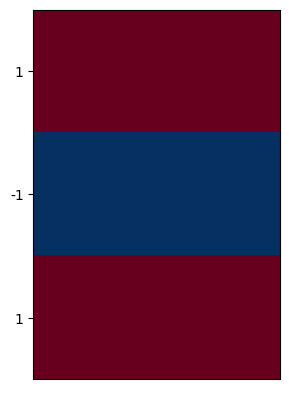

In [7]:
plt.imshow([[1,1],[0,0],[1,1]], cmap=plt.cm.RdBu_r);
plt.xticks([]);
plt.yticks([0,1,2], labels=[1,-1,1]);

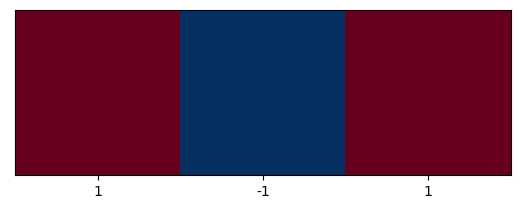

In [8]:
plt.imshow([[1,0,1]], cmap=plt.cm.RdBu_r);
plt.xticks([0,1,2], labels=[1,-1,1]);
plt.yticks([]);

In [9]:
xkernel_diff = np.zeros((1, 3))
xkernel_diff[0, :] = np.array([1,-2,1])

In [10]:
ykernel_diff = np.zeros((3,1))
ykernel_diff[:, 0] = np.array([1,-2,1])

Just as we did with advection, we implement a diffuse function using multiple dispatch:



In [11]:
class OceanModel():
    
    def __init__(self, T, deltat, windfield, grid, kappa):
        
        self.T = [T]
        self.u = windfield.u
        self.v = windfield.v
        self.deltay = grid.deltay
        self.deltax = grid.deltax
        self.deltat = deltat
        self.kappa = kappa
        self.i = np.arange(0, self.T[0].shape[1])
        self.j = np.arange(0, self.T[0].shape[0])
        self.t = [0]
        self.diffuse_out = []
        self.advect_out = []
        self.t_ = []

    def advect(self, T):
        T_advect = np.zeros((self.j.size, self.i.size))
        for j in range(1, T_advect.shape[0] - 1):
            for i in range(1, T_advect.shape[1] - 1):
                T_advect[j, i] = -(self.u[j, i] * np.sum(xkernel[0, :] * T[j, i-1:i+2])/(2*self.deltax) + \
                                   self.v[j, i] * np.sum(ykernel[:, 0] * T[j-1:j+2, i])/(2*self.deltay))
        return T_advect
                
    def diffuse(self, T):
        T_diffuse= np.zeros((self.j.size, self.i.size))
        for j in range(1, T_diffuse.shape[0] - 1):
            for i in range(1, T_diffuse.shape[1] - 1):
                T_diffuse[j, i] = self.kappa*(np.sum(xkernel_diff[0, :] * T[j, i-1:i+2])/(self.deltax**2) + \
                                              np.sum(ykernel_diff[:, 0] * T[j-1:j+2, i])/(self.deltay**2))      
        return T_diffuse

## 2.3) No-flux boundary conditions

We want to impose the no-flux boundary conditions, which states that

$$u\frac{\partial T}{\partial x} = \kappa \frac{\partial T}{\partial x} = 0$$ at $x$ boundaries and 

$$v\frac{\partial T}{\partial y} = \kappa \frac{\partial T}{\partial y} = 0$$ at the $y$ boundaries.

To impose this, we treat $i=1$ and $i=N_{x}$ as *ghost cells*, which do not do anything expect help us impose these boundaries conditions. Discretely, the boundary fluxes between $i=1$ and $i=2$ vanish if

$$\dfrac{T_{2,\,j}^{n} -T_{1,\,j}^{n}}{\Delta x} = 0$$ or 

$$T_{1,\,j}^{n} = T_{2,\,j}^{n}.$$

Thus, we can implement the boundary conditions by updating the temperature of the ghost cells to match their interior-point neighbors:

In [12]:
def update_ghostcells(var):
    var[0, :] = var[1, :];
    var[-1, :] = var[-2, :]
    var[:, 0] = var[:, 1]
    var[:, -1] = var[:, -2]
    return var

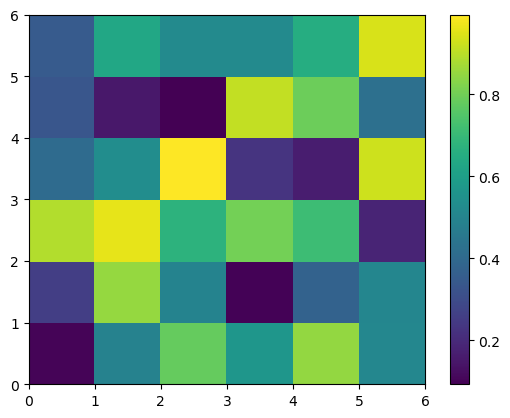

In [13]:
B = np.random.rand(6,6)
plt.pcolor(B)
plt.colorbar()

In [14]:
B = update_ghostcells(B)

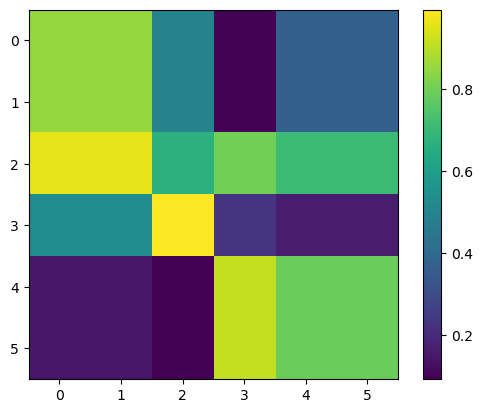

In [15]:
plt.imshow(B)
plt.colorbar()

## 2.4) Timestepping

In [16]:
class OceanModel():
    
    def __init__(self, T, deltat, windfield, grid, kappa):
        
        self.T = [T]
        self.u = windfield.u
        self.v = windfield.v
        self.deltay = grid.deltay
        self.deltax = grid.deltax
        self.deltat = deltat
        self.kappa = kappa
        self.i = np.arange(0, self.T[0].shape[1])
        self.j = np.arange(0, self.T[0].shape[0])
        self.t = [0]
        self.diffuse_out = []
        self.advect_out = []
        self.t_ = []

    def advect(self, T):
        T_advect = np.zeros((self.j.size, self.i.size))
        for j in range(1, T_advect.shape[0] - 1):
            for i in range(1, T_advect.shape[1] - 1):
                T_advect[j, i] = -(self.u[j, i] * np.sum(xkernel[0, :] * T[j, i-1:i+2])/(2*self.deltax) + \
                                   self.v[j, i] * np.sum(ykernel[:, 0] * T[j-1:j+2, i])/(2*self.deltax))
        return T_advect
                
    def diffuse(self, T):
        T_diffuse= np.zeros((self.j.size, self.i.size))
        for j in range(1, T_diffuse.shape[0] - 1):
            for i in range(1, T_diffuse.shape[1] - 1):
                T_diffuse[j, i] = self.kappa*(np.sum(xkernel_diff[0, :] * T[j, i-1:i+2])/(self.deltax**2) + \
                                              np.sum(ykernel_diff[:, 0] * T[j-1:j+2, i])/(self.deltay**2))      
        return T_diffuse
    
    def timestep(self):
        T_ = self.T[-1].copy()
        T_ = update_ghostcells(T_)
        tendencies = self.advect(self.T[-1]) + self.diffuse(self.T[-1])
        T_ = self.deltat * tendencies + T_
        self.T.append(T_)
        self.t.append(self.t[-1] + self.deltat)

In [17]:
class grid:   
    """ Creates grid for ocean model
    Args:
    -------
    
    N: Number of grid points (NxN)
    L: Length of domain
    """
    def __init__(self, N, L):
        self.deltax = L / N
        self.deltay = L / N
        self.xs = np.arange(0-self.deltax/2, L+self.deltax/2, self.deltax) 
        self.ys = np.arange(-L-self.deltay/2, L+self.deltay/2, self.deltay)   

        self.N = N
        self.L = L
        self.Nx = len(self.xs)
        self.Ny = len(self.ys)
        self.grid, _= np.meshgrid(self.ys, self.xs, sparse=False, indexing='ij')
        
class windfield:
    """Calculates wind velocity
    
    Args:
    ------
    Grid: class grid()
    option: zero, or single gyre
    
    """
    
    def __init__(self, grid, option = "zero"):
        if option == "zero":
            self.u = np.zeros((grid.grid.shape))
            self.v = np.zeros((grid.grid.shape))
        if option == "single_gyre":
            u, v = PointVortex(my_grid)
            self.u = u
            self.v = v
            

Initialize $10x10$ grid domain with $L=6000000m$ and a windfield, where all velocities are set to zero.
This should result in diffusion only.

Initialize temperature field with rectangular non-zero box.

In [18]:
my_grid = grid(N = 11, L = 6e6)
my_wind = windfield(my_grid, option = "zero")
my_temp = np.zeros((my_grid.grid.shape)) 
my_temp[9:13, 4:8] = 1

In [19]:
my_grid.grid.shape

(23, 12)

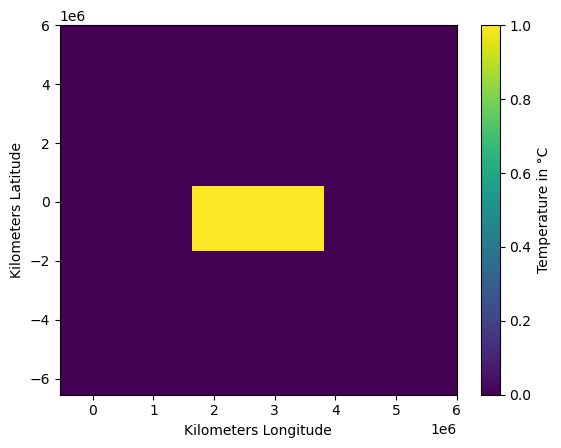

In [20]:
plt.pcolor(my_grid.xs, my_grid.ys, my_temp)
plt.colorbar(label = "Temperature in °C");
plt.ylabel("Kilometers Latitude");
plt.xlabel("Kilometers Longitude");

In [21]:
deltat = 12*60*60 # 12 Hours

In [22]:
def plot_func(steps, temp, deltat, windfield, grid, kappa, anomaly = False):
    my_model = OceanModel(T=temp,
                      deltat=deltat, 
                      windfield=windfield, 
                      grid=grid, 
                      kappa = kappa)
    for step in range(steps):
        my_model.timestep()   
    plt.figure(figsize=(8,8))
    lon, lat = np.meshgrid(grid.xs, grid.ys)
    if anomaly == True:
        plt.pcolor(my_grid.xs, my_grid.ys, my_model.T[-1] - my_model.T[-2], cmap = plt.cm.RdBu_r,
                  vmin = -0.001, vmax = 0.001)
    else:
        plt.pcolor(my_grid.xs, my_grid.ys, my_model.T[-1], vmin = 0, vmax = 1)
    plt.quiver(lon, lat, windfield.u, windfield.v)
    plt.colorbar(label = "Temperature in °C");
    plt.ylabel("Kilometers Latitude");
    plt.xlabel("Kilometers Longitude"); 
    plt.title("Time: {} days".format(int(step/2)))
    plt.show()

In [23]:
interact(plot_func, 
         temp = fixed(my_temp),
         deltat = fixed(deltat),
         windfield = fixed(my_wind),
         grid = fixed(my_grid),
         kappa = fixed(1e4),
         anomaly = widgets.Checkbox(description = "Anomaly", value=False),
         steps = widgets.IntSlider(description="Timesteps", value = 2, min = 1, max = 10000, step = 1));

interactive(children=(IntSlider(value=2, description='Timesteps', max=10000, min=1), Checkbox(value=False, des…

## Create single gyre windfield

In [23]:
def diagnose_velocities(stream, G):    
    dx = np.zeros((G.grid.shape))
    dy = np.zeros((G.grid.shape))
    
    dx = (stream[:, 1:] - stream[:, 0:-1])/G.deltax
    dy = (stream[1:, :] - stream[0:-1, :])/G.deltay
    
    u = np.zeros((G.grid.shape))
    v = np.zeros((G.grid.shape))
    
    u = 0.5*(dy[:, 1:] + dy[:, 0:-1])
    v = -0.5*(dx[1:, :] + dx[0:-1, :])
    
    return u, v

In [24]:
def impose_no_flux(u, v):
    u[0, :]  = 0; v[0, :] = 0;
    u[-1,:]  = 0; v[-1,:] = 0;
    u[:, 0]  = 0; v[:, 0] = 0;
    u[:,-1]  = 0; v[:,-1] = 0;
    
    return u, v

In [25]:
def PointVortex(G, omega = 0.6, a = 0.2, x0=0.5, y0 = 0.):
    x = np.arange(-G.deltax/G.L, 1 + G.deltax / G.L, G.deltax / G.L).reshape(1, -1)
    y = np.arange(-1-G.deltay/G.L, 1+ G.deltay / G.L, G.deltay / G.L).reshape(-1, 1)
    
#     x = x[:,:-1]    
    
    r = np.sqrt((y - y0)**2 + (x - x0)**2)
    stream = -omega/4*r**2 
    stream[r > a] =  -omega*a**2/4*(1. + 2*np.log(r[r > a]/a))
    
    u, v =  diagnose_velocities(stream, G)
    u, v = impose_no_flux(u, v) 
    u = u * G.L; v = v * G.L
    return u, v

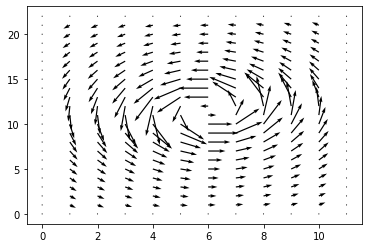

In [26]:
my_wind = windfield(my_grid, option="single_gyre")
plt.quiver(my_wind.u, my_wind.v)

In [39]:
my_temp = np.zeros((my_grid.grid.shape)) 
my_temp[8:13, :] = 1

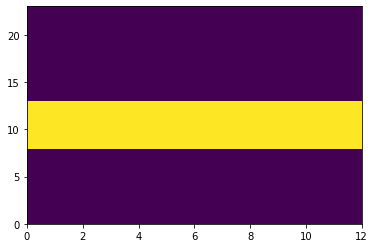

In [40]:
plt.pcolor(my_temp)

In [41]:
my_model = OceanModel(T=my_temp,
                      deltat=deltat, 
                      windfield=my_wind, 
                      grid=my_grid, 
                      kappa = 1e4)

In [42]:
interact(plot_func, 
         temp = fixed(my_temp),
         deltat = fixed(deltat),
         windfield = fixed(my_wind),
         grid = fixed(my_grid),
         kappa = widgets.IntSlider(description="kappa", value = 1e4, min=1e3, max = 1e5, step = 100),
         anomaly = widgets.Checkbox(description = "Anomaly", value=False),
         steps = widgets.IntSlider(description="Timesteps", value = 1, min = 1, max = 1000, step = 1));

interactive(children=(IntSlider(value=1, description='Timesteps', max=1000, min=1), IntSlider(value=10000, des…

ToDo add two gyre

In [ ]:
u, v = PointVortex(my_grid)
u, v = u[1:], v[1:]

In [ ]:
my_grid.grid.shape

In [ ]:
print(u.shape)

In [ ]:
epsilon = 0.05
xpsi = np.arange(-deltax, 1+deltax, deltax)
ypsi = np.arange(-1-deltay, 1+deltay, deltay)

def psihat(x, y):
    psi = np.zeros((x.size, y.size))
    np.psi
    

In [ ]:
psi = np.zeros((ypsi.size, xpsi.size))

for i, x in enumerate(xpsi):
    for j, y in enumerate(ypsi):
        psi[j, i] = np.pi * np.sin(np.pi * y) * (
        1 - x - np.exp(-x/(2*epsilon)) *
            (np.cos(np.sqrt(3)*x/(2*epsilon)) + (1 / np.sqrt(3)) * np.sin(np.sqrt(3)*x/(2*epsilon)))+epsilon*np.exp((x-1)/epsilon))
        
        


In [ ]:
plt.pcolor(psi)
plt.colorbar()

In [ ]:
np.pi * np.sin(np.pi * y) * (
        1 - x - np.exp(-x/(2*epsilon)) *
            (np.cos(np.sqrt(3)*x/(2*epsilon)) + (1 / np.sqrt(3)) * np.sin(np.sqrt(3)*x/(2*epsilon)))+epsilon*np.exp((x-1)/epsilon))